# M4 - Minería y clasificación de textos

#### Félix Rodríguez Lagonell

### Introducción

El propósito de esta tarea es familiarizarnos con el uso de la api de twitter para, posteriormente, llevar a cabo un análisis de clasificación de los tweets recopilados.

#### Carga de librerías

Importamos las librerías principales que nos serán necesarias a lo largo de todo el código. También realizamos la autentificación en la api de twitter.

In [1]:
import tweepy as tw
import pandas as pd
import numpy as np
import datetime
import json
import csv
import matplotlib.pyplot as plt
import re
import nltk
#nltk.download()
nltk.data.path.append('/home/user/Descargas/nltk_data')
from nltk.corpus import stopwords
%matplotlib inline

consumer_key = 'changeme'
consumer_secret = 'changeme'
token = 'changeme'
secret = 'changeme'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(token, secret)

api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [ ]:
# I am

me = api.me()
print("Name: ", me.name)
print("Nick: ", me.screen_name)
print("Description: ", me.description)

In [ ]:
# My timeline

public_tweets = api.home_timeline(count=2)
for tweet in public_tweets:
    print(f"{tweet.user.name} --> {tweet.text}")

In [ ]:
# My followers

followers = api.followers()
for follower in followers:
    print(follower.screen_name)

In [5]:
# Xataka

xataka_tweets = api.user_timeline('xataka', count=2)  # api.user_timeline()
for tweet in xataka_tweets:
    print(f"{tweet.user.name} --> {tweet.text}")

xataka --> General Motors está presionando a las autoridades para poner en la calle sus coches autónomos sin volante ni pedale… https://t.co/K4XrU2juB9
xataka --> ⚡️El juego de mesa más vendido de Amazon España fue creado por tres aficionados a los juegos de cartas y es español… https://t.co/eFtelUj1CF


In [6]:
print(xataka_tweets[0].created_at)

2019-12-24 19:10:06


In [7]:
api.user_timeline(screen_name='xataka', count=2, tweet_mode='extended', include_retweets=True)

[Status(_api=<tweepy.api.API object at 0x7f4fc5f6baf0>, _json={'created_at': 'Tue Dec 24 19:10:06 +0000 2019', 'id': 1209551844026015745, 'id_str': '1209551844026015745', 'full_text': 'General Motors está presionando a las autoridades para poner en la calle sus coches autónomos sin volante ni pedales en 2020 https://t.co/2o21OfFQdZ https://t.co/hOeVoRzHvD', 'truncated': False, 'display_text_range': [0, 148], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/2o21OfFQdZ', 'expanded_url': 'https://www.xataka.com/p/220614', 'display_url': 'xataka.com/p/220614', 'indices': [125, 148]}], 'media': [{'id': 1209551842113413120, 'id_str': '1209551842113413120', 'indices': [149, 172], 'media_url': 'http://pbs.twimg.com/media/EMkw_e6W4AA2v0b.jpg', 'media_url_https': 'https://pbs.twimg.com/media/EMkw_e6W4AA2v0b.jpg', 'url': 'https://t.co/hOeVoRzHvD', 'display_url': 'pic.twitter.com/hOeVoRzHvD', 'expanded_url': 'https://twitter.com/xataka/status/12095518

In [8]:
# If you want a JSON

#public_tweets[0]

status = public_tweets[0]

# Convert to string
json_str = json.dumps(status._json)

# Deserialise string into python object
parsed = json.loads(json_str)

print(json.dumps(parsed, indent=4, sort_keys=True))

{
    "contributors": null,
    "coordinates": null,
    "created_at": "Tue Dec 24 20:42:21 +0000 2019",
    "entities": {
        "hashtags": [
            {
                "indices": [
                    14,
                    23
                ],
                "text": "epicfail"
            }
        ],
        "symbols": [],
        "urls": [
            {
                "display_url": "instagram.com/p/B6d_jxGhCn4/\u2026",
                "expanded_url": "https://www.instagram.com/p/B6d_jxGhCn4/?igshid=185xedb9yoev3",
                "indices": [
                    24,
                    47
                ],
                "url": "https://t.co/RdBT2tTdr3"
            }
        ],
        "user_mentions": []
    },
    "favorite_count": 18,
    "favorited": false,
    "geo": null,
    "id": 1209575060584968193,
    "id_str": "1209575060584968193",
    "in_reply_to_screen_name": null,
    "in_reply_to_status_id": null,
    "in_reply_to_status_id_str": null,
    "in_reply_t

In [9]:
date_since = "2019-12-05"
tweets = tw.Cursor(api.search,
              q="#ransomware",
              lang="en",
              since=date_since).items(5)

users_locs = [print(tweet.user.id) for tweet in tweets]
#tweet_text = pd.DataFrame(data=users_locs, 
                    #columns=['user', "location"])
type(tweets)

714480767120838656
993154328
2716112014
710123736175783938
1142424032794406912


tweepy.cursor.ItemIterator

In [10]:
# Location of the last user.id

tweet.user.location
#tweet.describe()

'España y Latinoamérica'

### Streaming

Tras autenticarnos correctamente pasamos a recopilar todos los tweets relacionados con nuestra temática de interés mediante una lista de palabras clave. Guardaremos los tweets en un archivo .csv en nuestro directorio de trabajo.

* filters_x -> lista de palabras de interés. Por ejemplo, filters_s(ecurity) recoge tweets relacionados con la temática 'ciberseguridad' mientras que los tweets filtrados por filters_c(limate) tienen que ver con 'cambio climático'.
* tweets_x -> sigue la misma casuística que filters_x

Nota: Es necesario cambiar manualmente tanto la temática (filters_x) como del archivo csv (tweets_x.csv)

In [11]:
class MyStreamListener(tw.StreamListener):
    def __init__(self, api):
        self.api = api
        self.me = api.me()

    def on_status(self, tweet):
        print(f"{tweet.user.name} -> {tweet.text}")
        mined = {
            'Tweet_id':        tweet.id,
            'Name':            tweet.user.name,
            'Screen_Name':     tweet.user.screen_name,
            'User_Description':tweet.user.description,
            'Retweet_Count':   tweet.retweet_count,
            'Text':            tweet.text,
            'Retweeted':       tweet.retweeted,
            'Mined_at':        datetime.datetime.now(),
            'Created_at':      tweet.created_at,
            'Favourite_Count': tweet.favorite_count,
            'Hashtags':        tweet.entities['hashtags'],
            'Status_Count':    tweet.user.statuses_count,
            'Location':        tweet.place,
            'Coordinates':     tweet.coordinates,
            'Device':          tweet.source
        }
        
        # To json uncomment following lanes
        #json_str = json.dumps(tweet._json)
        with open('tweets_c.csv', "a") as file:
            csv_writer = csv.DictWriter(file, delimiter=',', fieldnames=list(mined.keys()), lineterminator='\n')
            
            if file.tell() == 0: # .tell() say the position -> to not repeat headers
                csv_writer.writeheader()
                
            csv_writer.writerow(mined)
            #json.dump(tweet._json, file, indent=4)
            #file.write(json_str)

    def on_error(self, status):
        print("Error detected")
        return False
        
        
tweets = MyStreamListener(api)
stream = tw.Stream(auth=api.auth, listener=tweets)

# tweets_s.csv
filters_s = ["ciberseguridad", "hacker", "botnet", "ddos", "firewall",
           "cybersecurity", "cracker", "ransomware", "antivirus", "DDOS",
           "pastebin", "malware", "backdoor", "zero day", "exploit",
           "phishing", "sqlinjection", "pentest", "pharming", "spoofing", "SOC",
           "emotet", "wannacry", "adware", "spyware", "troyano", "0-day", "zero-day"]

# tweets_c.csv
filters_c = ["medioambiente", "renovable", "calentamiento", "carbon", "deforestacion", "aerosoles",
           "eolica", "solar", "clima", "emisiones", "invernadero", "ozono", "vertidos", "biosfera",
           "contaminacion", "polucion", "sequia", "reforestacion", "desertificacion", "atmosfera",
           "climatico", "climatica", "biocarburante", "biodiversidad", "inundaciones", "glaciares",
           "climático", "climática", "acidificacion", "co2", "carbono", "kyoto" ]

try:
    print('Starting Stream')
    print(" ")
    stream.filter(track=filters_c, languages=["es"])  # Change filters manually!!!
    
except KeyboardInterrupt:
    print(" ")
    print('Stopping Stream')
    
finally:
    print(" ")
    print('Done')
    stream.disconnect()

Starting Stream
 
Fabián Parraguez -> RT @biobio: 🔴 AHORA | Se registran inundaciones en las calles de #SanAntonio por presunta rotura de matriz. https://t.co/XWD8MhPxCQ
ARMANDO PELAEZ -> RT @Miriam_Junne: Así es, ahí la llevamos arreglando las cochinadas que hiciste. Lo entregaste sin planes completos y L final costó 5 veces…
Lecturas 24H 🇪🇸 -> 🛡️ 4 situaciones que podrían matarnos antes de que el planeta se quede sin nubes por el cambio climático… https://t.co/62DVqrJCjY
kellys johanna -> RT @GestionRiesgoSM: La #AlcaldíaDelCambio a través de la Oficina Para la Gestión del Riesgo y el Cambio Climático de Santa Marta (#Ogricc)…
EMS -> RT @acastagne: Presidente @lopezobrador_ inaugura obra sumamente importante para la Ciudad De México iniciada en el mandato del Ex Presiden…
janeth -> RT @Noragrm: a ok con el clima
 
Stopping Stream
 
Done


### Filtrado

Tras la recogida de tweets definimos la función 'remove_url_cha' que nos será útil para eliminar URLs y caracteres especiales. Además, mediante 'stopwords.words' (nltk), 'abc' (ascii_lowercase) y 'more_sw' eliminaremos adverbios, monosílabos, posibles letras sueltas y/o palabras que nos interesen filtrar. También eliminaremos de nuestro conjunto de datos las palabras que nos han servido para elegir la temática (filters_x) dado que nos interesa la frecuencia de palabras relacionadas con esos términos.

In [12]:
from string import ascii_lowercase as abc

def remove_url_cha(txt):
    
    # Remove url and characters
    
    #^http(s)?:\/\/((\d+\.\d+\.\d+\.\d+)|(([\w-]+\.)+([a-z,A-Z][\w-]*)))(:[1-9][0-9]*)?(\/([\w-.\/:%+@&=]+[\w- .\/?:%+@&=]*)?)?((.*))?$
    txt = re.sub(r'^https?:\/\/.*[\r\n]*|^www.*|http.*', '', txt, flags=re.MULTILINE)
    txt = re.sub(r'^@.*', '', txt)
    txt = re.sub(r'^#.*', '', txt)
    txt = re.sub(r'\d*|\W*', '', txt)
    
    return txt

sw = stopwords.words('spanish')
more_sw = ['rt', 'kk', 'kmh', 'tan', 'si']
[sw.append(i) for i in more_sw]
[sw.append(i) for i in abc]

# sws contain all filters for cyber
sws = sw
[sws.append(i) for i in filters_s]

# sws contain all filters for climate
swc = sw
[swc.append(i) for i in filters_c]

print('Filters loaded')


Filters loaded


### Análisis de texto

A continuación realizamos la carga de datos en un dataframe y aplicamos los filtros del apartado anterior para las dos temáticas elegidas.

Reduciremos dicho dataframe a otro que sólo contenga las columnas nombre, nick de usuario, texto del tweet, fecha de cración y localización geográfica. A su vez crearemos una columna que contenga la hora del tweet, otra para el número de palabras de cada tweet y una última para el número de caracteres por tweet.

##### Ciberseguridad

In [13]:
dfo = pd.read_csv('tweets_s.csv', header=0)#, usecols=['Name', 'Screen_Name', 'Text', 'Created_at', 'Location'])
columns_to_keep = ['Name', 'Screen_Name', 'Text', 'Created_at', 'Location']
dfs = dfo[columns_to_keep].copy()

dfs['Text_Hour'] = pd.to_datetime(dfs['Created_at'])
dfs['Text_Hour'] = dfs['Text_Hour'].apply(lambda x: x.hour)

dfs['Text_Words'] = dfs['Text'].str.count(' ') +1

dfs['Text_Characters'] = dfs['Text'].str.len()
dfs.head()

,Name,Screen_Name,Text,Created_at,Location,Text_Hour,Text_Words,Text_Characters
0,Lucio J. Aray P.,luciojap,RT @wwwhatsnew: Nuestro NAS puede sufrir amena...,2019-12-09 02:21:59,NaN,2,11,92
1,Leonel Maye,casimaye,Ciber Recetario https://t.co/zcp79xamR7 Gracia...,2019-12-09 02:22:05,NaN,2,10,125
2,Richard MX RED_AMLO 2.O,Richard_Pumas07,RT @contralinea: Preparan órdenes de aprehensi...,2019-12-09 02:22:14,NaN,2,15,131
3,punto tecnologico,Point_tecno,wwwhatsnew: Nuestro NAS puede sufrir amenazas ...,2019-12-09 02:22:14,NaN,2,10,88
4,Badí Quinteros بدیع ۞,badiquinteros,RT @OEA_Cyber: ¿Cómo incrementar la #cibersegu...,2019-12-09 02:22:53,NaN,2,21,140


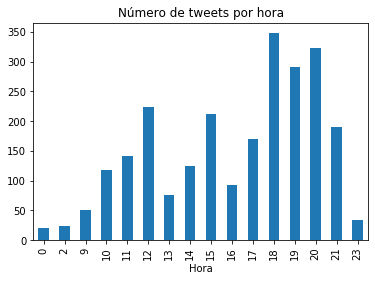

In [14]:
dfs['N'] = 1
#(dfs.set_index('Text_Hour').groupby(level=0)['N'].agg(Tweets_per_hour = np.sum))
dfs.groupby('Text_Hour').N.count().plot.bar(ylim=0)
plt.title('Número de tweets por hora')
plt.xlabel('Hora')
plt.show()

Podemos ver las horas del día con mayor actividad para la temática 'ciberseguridad'. A continuación graficamos la frecuencia de palabras contenidas en cada tweet sin incluir aquellas que nos han servido para elegir la temática. Con ello veremos qué palabras tienen mayor ponderación en relación a la temática elegida y por consiguiente tendrán mayor relevancia a la hora de clasificar nuestros tweets.

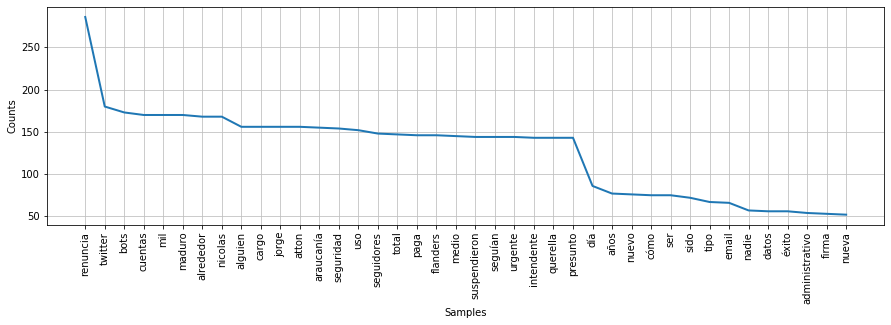

In [15]:
token = dfs['Text'].apply(lambda x: x.lower().split())
token = [j for i in token.values.tolist() for j in i]
token = [remove_url_cha(i) for i in token]

token = [x for x in token if x not in sw]
token = ' '.join(token).split()
token_s = token

plt.figure(figsize=(15, 4))
freqs = nltk.FreqDist(token_s)
freqs.plot(40, cumulative=False)

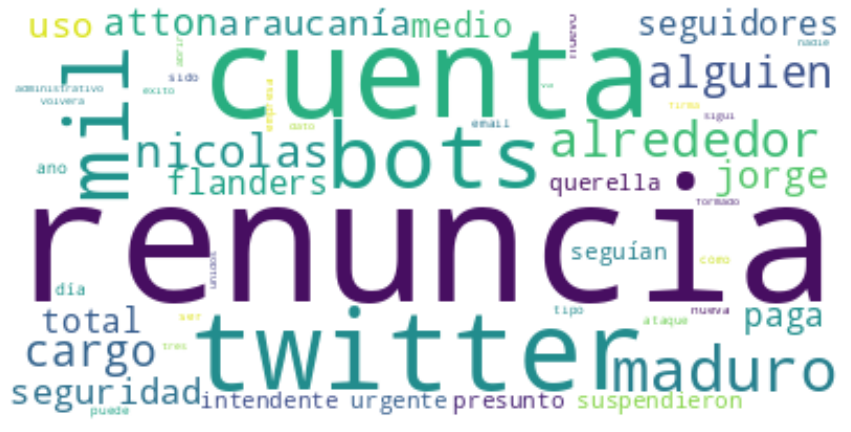

In [16]:
from wordcloud import WordCloud

w = ' '.join(token)
wordcloud = WordCloud(max_font_size=900, max_words=50, background_color="white", 
                      relative_scaling=1, repeat=False, collocations=False).generate(w)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### Cambio climático

Seguimos nuestro análisis para la otra temática: 'cambio climático'.

In [17]:
dfo = pd.read_csv('tweets_c.csv', header=0)#, usecols=['Name', 'Screen_Name', 'Text', 'Created_at', 'Location'])
columns_to_keep = ['Name', 'Screen_Name', 'Text', 'Created_at', 'Location']
dfc = dfo[columns_to_keep].copy()

dfc['Text_Hour'] = pd.to_datetime(dfc['Created_at'])
dfc['Text_Hour'] = dfc['Text_Hour'].apply(lambda x: x.hour)

dfc['Text_Words'] = dfc['Text'].str.count(' ') +1

dfc['Text_Characters'] = dfc['Text'].str.len()
dfc.head()


,Name,Screen_Name,Text,Created_at,Location,Text_Hour,Text_Words,Text_Characters
0,Eduardo.jpgr,JpgrEduardo,RT @patablanco: al flamante ministro de medioa...,2019-12-08 21:04:56,NaN,21,22,140
1,ANATO Nacional,AnatoNacional,¿El turismo de naturaleza ayuda en la conserva...,2019-12-08 21:05:03,NaN,21,14,122
2,JuanMa,jmjuarezlopez,La lucha contra el cambio climático transforma...,2019-12-08 21:05:04,NaN,21,11,95
3,Jorge Alonso Pérez.,haclum72,RT @AntonioMyc00: Muy esclarecedor ver el víde...,2019-12-08 21:05:09,NaN,21,22,140
4,nicogarcia1,nicogarciat,RT @nefeerr: “Estamos perdiendo la batalla con...,2019-12-08 21:05:14,NaN,21,11,94


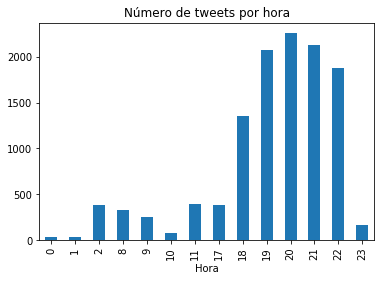

In [18]:
dfc['N'] = 1
#(dfc.set_index('Text_Hour').groupby(level=0)['N'].agg(Tweets_per_hour = np.sum))
dfc.groupby('Text_Hour').N.count().plot.bar(ylim=0)
plt.title('Número de tweets por hora')
plt.xlabel('Hora')
plt.show()

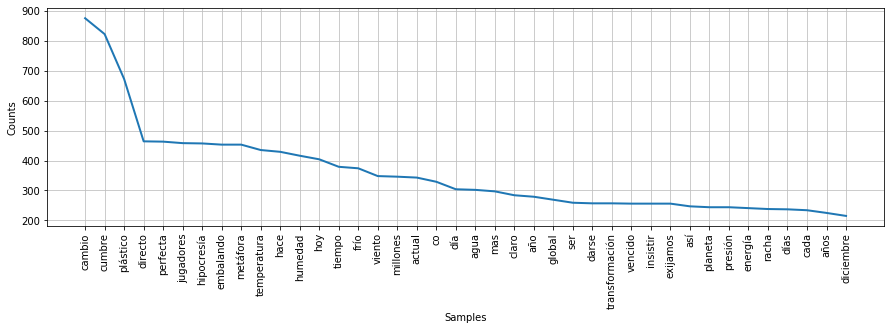

In [19]:
token = dfc['Text'].apply(lambda x: x.lower().split())
token = [j for i in token.values.tolist() for j in i]
token = [remove_url_cha(i) for i in token]

token = [x for x in token if x not in sw]
token = ' '.join(token).split()
token_c = token

plt.figure(figsize=(15, 4))
freqc = nltk.FreqDist(token_c)
freqc.plot(40, cumulative=False)

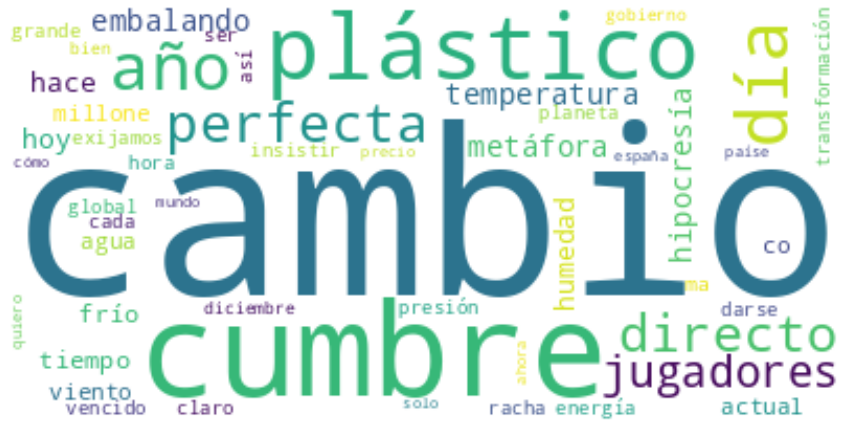

In [20]:
w = ' '.join(token)
wordcloud = WordCloud(max_font_size=900, max_words=50, background_color="white", 
                      relative_scaling=1, repeat=False, collocations=False).generate(w)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Clasificación de textos

A continuación desarrollaremos un modelo de clasificación de texto. Dado un nuevo tweet intentaremos predecir la categoría a la que pertenece en base a los tweets recopilados.

Primero creamos una nueva columna para cada dataframe que constituye la variable objetivo.

In [21]:
dfs['Target'] = 'Cyber'
dfc['Target'] = 'Climate'
dff = pd.concat([dfs, dfc], ignore_index=True)

Preparamos nuestro set de entrenamiento y test:

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

xs_train, xs_test, ys_train, ys_test = train_test_split(dfs['Text'], dfs['Target'], test_size=0.3)
xc_train, xc_test, yc_train, yc_test = train_test_split(dfc['Text'], dfc['Target'], test_size=0.3)
#x_train, x_test, y_train, y_test = train_test_split(dff['Text'], dff['Target'], test_size=0.3)
x_train = pd.concat([xs_train, xc_train], ignore_index=True)
x_test = pd.concat([xs_test, xc_test], ignore_index=True)
y_train =pd.concat([ys_train, yc_train], ignore_index=True)
y_test = pd.concat([ys_test, yc_test], ignore_index=True)

Vectorizamos y tokenizamos nuestros tweets con scikit-learn:

In [23]:
count_vect = CountVectorizer()
x_train_counts = count_vect.fit_transform(x_train)
#x_train_counts.shape

tf_transformer = TfidfTransformer(use_idf=False).fit(x_train_counts)
x_train_tf = tf_transformer.transform(x_train_counts)
#x_train_tf.shape

tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
#x_train_tfidf.shape

Ahora que hemos extraído las características principales de los tweets, estamos en disposición de entrenar el clasificador. En primer lugar usaremos Naive-Bayes:

In [24]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(x_train_tfidf, y_train)

x_new_counts = count_vect.transform(x_test)
x_new_tfidf = tfidf_transformer.transform(x_new_counts)
y_pred = clf.predict(x_new_tfidf)
print('Accuracy: ', np.mean(y_pred == y_test))


Accuracy:  0.9397363465160076


In [25]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=dff['Target'].unique()))

              precision    recall  f1-score   support

       Cyber       0.93      1.00      0.96      3517
     Climate       1.00      0.65      0.79       731

    accuracy                           0.94      4248
   macro avg       0.97      0.82      0.88      4248
weighted avg       0.94      0.94      0.93      4248



La media de aciertos tiene valor (muy cercano a) 1, lo cual es un indicio de overfitting. 

Veamos si nuestro clasificador es capaz de asignar la temática correcta con una frase de ejemplo:

In [26]:
print(clf.predict(count_vect.transform(["El aumento de temperatura es nocivo para los corales"])))
print(clf.predict(count_vect.transform(["Bancos salen perjudicados por ataques informáticos"])))

['Climate']
['Cyber']


El clasificador se comporta como esperamos. Una manera más cómoda de implementar el proceso de entrenamiento es mediante la clase 'Pipeline'. A continuación un ejemplo de su uso:

In [27]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB())])

text_clf.fit(x_train, y_train)
y_pred = text_clf.predict(y_test)

En general nos interesa llevar a cabo el estudio comparando distintos modelos de clasificación. En el siguiente código hacemos uso de la clase 'Pipeline' para entrenar distintos modelos a la vez y trataremos de reducir el overfitting mediante k-fold cross-validation:

In [28]:
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, x_train_tfidf, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['Model', 'K-fold', 'Accuracy'])
cv_df.groupby('Model').Accuracy.mean()


Model
LinearSVC                 0.977192
LogisticRegression        0.949339
MultinomialNB             0.936825
RandomForestClassifier    0.827934
SGDClassifier             0.927439
Name: Accuracy, dtype: float64

Y obtenemos una tabla con la media de precisión de cada modelo. Podemos ver que para todos los modelos tenemos un valor entorno a 0.9, es decir, un error del 10%.

Aunque los valores obtenidos son muy prometedores, no podemos asegurar que tenemos un buen modelo de clasificación. Esto se debe a que tan solo hemos usado dos temáticas para clasificar: 'ciberseguridad' y 'cambio climático'. Lo ideal sería recopilar una gran cantidad de tweets para entrenar el modelo sobre una amplia variedad de temas. Además, contribuye de forma negativa el hecho de que existe mucha redundancia en nuestro dataset de entrenamiento (tweetes repetidos o re-tweets a dichos tweets que no contienen diversidad linguística). 

A pesar de estos inconvenientes, lo que se ha pretendido con este trabajo es ofrecer una idea básica sobre extracción, transformación y carga (ETL) de datos extraídos de redes sociales junto con un análisis posterior e introductorio que resulta interesante para clasificar textos.

In [29]:
#from sklearn import tree
#from sklearn.cross_validation import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

#clasificador = tree.DecisionTreeClassifier()
#clasificador.fit(x_train, y_train)
#preds = clasificador.predict(x_test)

#clasificador.score(x_test, y_test)

### Links

https://realpython.com/twitter-bot-python-tweepy/

https://towardsdatascience.com/tweepy-for-beginners-24baf21f2c25

https://realpython.com/twitter-bot-python-tweepy/

https://towardsdatascience.com/selenium-tweepy-to-scrap-tweets-from-tweeter-and-analysing-sentiments-1804db3478ac

https://www.earthdatascience.org/courses/earth-analytics-python/using-apis-natural-language-processing-twitter/calculate-tweet-word-frequencies-in-python/

https://blog.hacemoscontactos.com/tag/tweepy/

https://pybonacci.org/2015/11/24/como-hacer-analisis-de-sentimiento-en-espanol-2/

https://www.datanalytics.com/

https://planetachatbot.com/construyendo-un-chatbot-simple-desde-cero-en-python-usando-nltk-31b9ae4f71db

https://www.dataquest.io/blog/streaming-data-python/

https://pythonprogramming.net/twitter-api-streaming-tweets-python-tutorial/

https://realpython.com/beautiful-soup-web-scraper-python/

https://hackernoon.com/auto-tinder-train-an-ai-to-swipe-tinder-for-you-dw23c3zj7